In [23]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import scipy.io as sio
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio

import torch
import torch.nn as nn
import torch.optim as optim

from utils import check_torch, pix2vid_dataset, DualCustomLoss, DualLpLoss, NeuralPix2Vid

In [24]:
NR, NT = 1272, 40
NX, NY = 40, 40
milli  = 1e-3
mega   = 1e6
Darcy  = 9.869233e-13
psi2pa = 6894.75729
co2rho = 686.5400
sec2yr = 1/(3600*24*365.25)
device = check_torch()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.3.1.post300 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
Torch device: cuda
------------------------------------------------------------


In [52]:
pressure = np.zeros((NT, NX, NY))
saturation = np.zeros((NT, NX, NY))
d = sio.loadmat('simulations_40x40/states/states_368.mat', simplify_cells=True)['var']
for j in tqdm(range(NT)):
    pressure[j] = d[j]['pressure'].reshape(NX, NY, order='F')
    saturation[j] = d[j]['s'].reshape(NX, NY, order='F')

temp = np.stack([pressure, saturation], axis=1)
print(temp.shape)

100%|██████████| 40/40 [00:00<00:00, 54260.08it/s]

(40, 2, 40, 40)


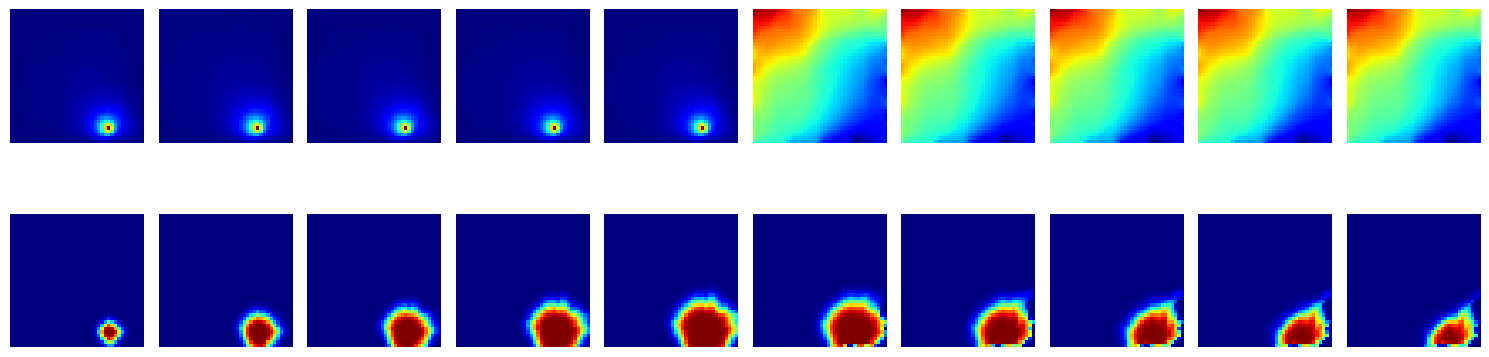

In [53]:
fig, axs = plt.subplots(2, 10, figsize=(15,5), sharex=True, sharey=True)
for i in range(2):
    for j in range(10):
        ax = axs[i,j]
        k = j*4+1
        ax.imshow(temp[k,i], cmap='jet')
        ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
tt = np.load('simulations_40x40/timesteps.npz')
timesteps, deltaTime = tt['timesteps'], tt['deltatime']
t0steps = timesteps[:20]
print('timesteps: {} | deltaT: {}'.format(len(timesteps), np.unique(deltaTime)))

tops2d = sio.loadmat('simulations_40x40/Gt.mat', simplify_cells=True)['Gt']['cells']['z'].reshape(NX,NY,order='F')
print('tops2d: {}'.format(tops2d.shape))

timesteps: 40 | deltaT: [  0.5 250. ]
tops2d: (40, 40)


In [5]:
folder = 'simulations_40x40'
X_data  = np.load('{}/X_data.npy'.format(folder))
c_data  = np.load('{}/c_data.npy'.format(folder)) * co2rho
y1_data = np.load('{}/y1_data.npy'.format(folder))
y2_data = np.load('{}/y2_data.npy'.format(folder))

In [16]:
X_data[:,1].max()

3.365964225243943e-15

In [ ]:
(Xt, ct, y1t, y2t, all_volumes, idx), (trainloader, validloader) = pix2vid_dataset(folder='simulations_40x40',
                                                                                   batch_size=8,
                                                                                   send_to_device=True, 
                                                                                   device=device)

In [ ]:
model = NeuralPix2Vid(device=device).to(device)
nparams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('# parameters: {:,} | device: {}'.format(nparams, model.device))
criterion = DualLpLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
start = time()
epochs, monitor = 10, 1
train_loss, valid_loss = [], []
for epoch in range(epochs):
    epoch_train_loss = []
    model.train()
    for i, (x,c,y1,y2) in enumerate(trainloader):
        optimizer.zero_grad()
        u1, u2 = model(x,c)
        loss = criterion(y1, y2, u1, u2)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        for i, (x,c,y1,y2) in enumerate(validloader):
            u1, u2 = model(x,c)
            loss = criterion(y1, y2, u1, u2)
            epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))
    # progress
    if (epoch+1) % monitor == 0:
        print('Epoch: [{}/{}] | Train Loss: {:.5f} | Valid Loss: {:.5f}'.format(epoch+1, epochs, train_loss[-1], valid_loss[-1]))

print('Total training time: {:.3f} minuts'.format((time()-start)/60))
torch.save(model.state_dict(), 'model.pth')
losses = pd.DataFrame({'train': train_loss, 'valid': valid_loss})
losses.to_csv('losses.csv', index=False)